In [1]:
SAVE = True

VERSION = 'Empirical Covariance' #'Empirical Covariance'  # 'Pseudoinverse', 'Gaussian Obs Model'

choose_x0 = 'all'
choose_model = 'all'
choose_binned_policy = 'ignore'

In [2]:
import sys
sys.path.append('..')
import data_utils
sys.path.append(data_utils.join_base_path('reallaborai4u/preprocessing'))
from feature_names import NON_CONDITIONAL_FEAT as LABELS
from feature_names import INTERACTIVE_NAMES, INTERVENTION_NAMES_EN
PRINT_LABELS = [l.removeprefix('EMA_') for l in LABELS]

### Find the proximal effects of each intervention on each EMA, stratified for momentary mood score (median split)

In [20]:
import pandas as pd
import numpy as np
import glob
from typing import Optional
from itertools import combinations
import os
import sys
sys.path.append('..')
import data_utils

# 'Positive affect', 'Negative affect', 'Self-esteem', 'Worrying', 'Activity level', 'Stress', 'Social isolation', 'Resilience', 'Emotion Regulation'

def get_proximal_effects_median_split_mood(data: pd.DataFrame, sum_over_emas: bool=True, binned_policy: str='ignore'):
    
    if binned_policy == 'ignore':
        data.loc[data['Form'] == 'binned', LABELS] = np.nan
    elif binned_policy == 'drop':
        data = data.loc[data['Form'] != 'binned']
    diff = data.set_index(['Participant'], append=True)
    diff = data[LABELS].diff().shift(-1)
    diff[INTERACTIVE_NAMES] = data[INTERACTIVE_NAMES]
    # Find low- and high-mood timepoints
    # low_mood_times = data['EMA_mood'] <= data['EMA_mood'].median()

    retain_indices = diff.notna().all(axis=1) & (diff[INTERACTIVE_NAMES].sum(axis=1) > 0)
    # diff = diff.dropna()
    # diff = diff.loc[diff[INTERACTIVE_NAMES].sum(axis=1)>0]
    diff = diff.loc[retain_indices]
    mood = data[LABELS].sum(axis=1).loc[retain_indices]    
    low_mood_times = mood < mood.median()

    # low_mood_times = low_mood_times.loc[retain_indices]
    EMI_occurrence_low_mood = diff.loc[low_mood_times, INTERACTIVE_NAMES].sum().astype(int)
    EMI_occurrence_low_mood[EMI_occurrence_low_mood==0] = np.nan
    EMI_occurrence_high_mood = diff.loc[~low_mood_times, INTERACTIVE_NAMES].sum().astype(int)
    EMI_occurrence_high_mood[EMI_occurrence_high_mood==0] = np.nan
    # Get the sum of effects of each intervention on each EMA
    sum_effects_low_mood = diff.loc[low_mood_times, LABELS].T.dot(diff.loc[low_mood_times, INTERACTIVE_NAMES])
    sum_effects_high_mood = diff.loc[~low_mood_times, LABELS].T.dot(diff.loc[~low_mood_times, INTERACTIVE_NAMES])
    # Normalize them by the number of intervention presentations
    sum_effects_low_mood = sum_effects_low_mood.div(EMI_occurrence_low_mood)
    sum_effects_high_mood = sum_effects_high_mood.div(EMI_occurrence_high_mood)
    if sum_over_emas:
        sum_effects_low_mood = sum_effects_low_mood.mean()
        sum_effects_high_mood = sum_effects_high_mood.mean()
    return sum_effects_low_mood, sum_effects_high_mood, EMI_occurrence_low_mood, EMI_occurrence_high_mood

Calculate proximal effects

In [21]:
import sys
sys.path.append('..')
from tqdm import tqdm
import torch as tc
import pandas as pd
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from bptt.plrnn import PLRNN

MRT = [2, 3]
effects = []
emi_occurrences = []

for mrt in MRT:

    mrt_effects = []
    mrt_emi_occurrences = []
    test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
    data_files = data_utils.get_data_files(test_data_dir)
    participants = data_utils.get_participant_ids(data_files)
    dist = {}
    for p, df in tqdm(data_utils.zip_participants_data(test_data_dir), total=len(participants), desc=f'Calculating proximal effects for MRT {mrt}'):    
        pe_low, pe_high, p_emi_occurrences_low, p_emi_occurrences_high = get_proximal_effects_median_split_mood(df, binned_policy=choose_binned_policy)
        # participant_emi_occurrences['participant'] = p
        mrt_effects.append(pd.concat([pe_low, pe_high], axis=1, keys=['low', 'high'], names=['mood']).T)
        mrt_emi_occurrences.append(pd.concat([p_emi_occurrences_low, p_emi_occurrences_high], axis=1, keys=['low', 'high'], names=['mood']).T)
    mrt_effects = pd.concat(mrt_effects, axis=0, keys=participants, names=['participant'])
    effects.append(mrt_effects)
    mrt_emi_occurrences = pd.concat(mrt_emi_occurrences, axis=0, keys=participants, names=['participant'])
    emi_occurrences.append(mrt_emi_occurrences)
effects = pd.concat(effects, axis=0, keys=MRT, names=['MRT']).swaplevel('participant', 'mood').sort_index()
emi_occurrences = pd.concat(emi_occurrences, axis=0, keys=MRT, names=['MRT']).swaplevel('participant', 'mood').sort_index()

Calculating proximal effects for MRT 3: 100%|██████████| 59/59 [00:00<00:00, 79.98it/s]


Plot proximal effects for low and high mood

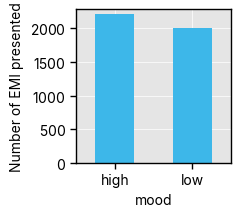

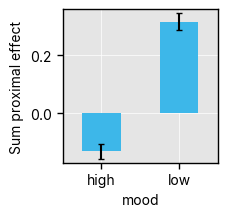

High mood mean effect: -0.129 ± 0.024
Low mood mean effect: 0.312 ± 0.029
Difference in mood mean effects: 0.182 ± 0.038
Absolute proximal effects low vs. high mood: t(111)=-5.679, p=0.000


In [29]:
import matplotlib.pyplot as plt
import plotting_utils
from scipy import stats

with PaperStyle():

    emis_per_mood = emi_occurrences.sum(axis=1).groupby('mood', sort=False).sum()
    mean_effects_per_mood = effects.mean(axis=1).groupby('mood', sort=False).mean()
    sem_effects_per_mood = effects.mean(axis=1).groupby('mood', sort=False).sem()

    fig, ax = plt.subplots(figsize=(2,2))
    emis_per_mood.plot(kind='bar', ax=ax, ylabel='Number of EMI presented', rot=0)
    plotting_utils.adjust_ylim(ax, top=0.03)
    fig, ax = plt.subplots(figsize=(2,2))
    mean_effects_per_mood.plot(kind='bar', yerr=sem_effects_per_mood, ax=ax, ylabel='Sum proximal effect', rot=0)
    plotting_utils.adjust_ylim(ax)
    if SAVE:
        plt.savefig(data_utils.join_ordinal_bptt_path('results', '_paper', f'emi_proximal_effects_median_split.svg'))
    plt.show()

    print(f'High mood mean effect: {mean_effects_per_mood.loc["high"].mean():.3f} ± {sem_effects_per_mood.loc["high"].mean():.3f}')
    print(f'Low mood mean effect: {mean_effects_per_mood.loc["low"].mean():.3f} ± {sem_effects_per_mood.loc["low"].mean():.3f}')
    print(f'Difference in mood mean effects: {mean_effects_per_mood.loc["high"].mean() + mean_effects_per_mood.loc["low"].mean():.3f} ± {np.sqrt(sem_effects_per_mood.loc["high"].mean()**2 + sem_effects_per_mood.loc["low"].mean()**2):.3f}')
    ttest_result = stats.ttest_rel(*[group for _, group in effects.mean(axis=1).abs().groupby('mood')], nan_policy='omit')
    print(f'Absolute proximal effects low vs. high mood: t({ttest_result.df:.0f})={ttest_result.statistic:.3f}, p={ttest_result.pvalue:.3f}')

Load models and predict the proximal effects for every intervention time step with newest model

In [23]:
import sys
sys.path.append('..')
from tqdm import tqdm
import torch as tc
import pandas as pd
import eval_reallabor_utils
import data_utils
import utils
from bptt.plrnn import PLRNN
from comparison_models.simple_models.models import KalmanFilter, VAR1

MRT = [2, 3]
plrnn_emi_cir = []
errors_loading_model = 0
ModelClass = PLRNN

for mrt in MRT:

    mrt_cir = []

    results_dir = data_utils.join_ordinal_bptt_path('results', f'v3_MRT{mrt}_every_day')
    test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')

    models = eval_reallabor_utils.ModelCatalogue(results_dir)
    data_files = data_utils.get_data_files(test_data_dir)
    participants = data_utils.get_participant_ids(data_files)
    dist = {}
    for p, df in tqdm(data_utils.zip_participants_data(test_data_dir), total=len(participants), desc=f'Calculating Impulse Responses for MRT {mrt}'):
        low_mood_times = df['EMA_mood'] < df['EMA_mood'].median()
        model_dirs = models.get_latest_model_dirs(p, timestep=1000)
        participant_cir = []
        for model_dir in model_dirs:
            model_cir = []
            args = utils.load_args(model_dir)
            model = ModelClass(args)
            model.init_from_model_path(model_dir)
            try:
                Gamma, B = eval_reallabor_utils.get_Gamma_and_B(model, model_dir, version=VERSION)
            except:
                errors_loading_model += 1
                continue
            dim_x, dim_s = args['dim_x'], args['dim_s']
            
            for initial_condition in [
                        tc.tensor(df.loc[low_mood_times, LABELS].to_numpy()).float(),
                       tc.tensor(df.loc[~low_mood_times, LABELS].to_numpy()).float(),
                        # tc.tensor(df.loc[df[INTERACTIVE_NAMES].sum(axis=1)>0, LABELS].to_numpy()).float(),
                      ]:
                cir = tc.zeros(dim_s)
                for i in range(dim_s):
                    perturbation = tc.zeros(dim_s).float()
                    perturbation[i] = 1
                    cir[i] = tc.nanmean(eval_reallabor_utils.impulse_response(model, perturbation, 1, cumulative=True, relative=True, x0=initial_condition, Gamma=Gamma, B=B))
                model_cir.append(cir.detach().numpy())
            model_cir = pd.DataFrame(model_cir, columns=INTERACTIVE_NAMES, index=['low', 'high'])
            model_cir['timestep'] = int(float(args['train_on_data_until_timestep']))
            model_cir.index.name = 'mood'
            participant_cir.append(model_cir)
        if len(participant_cir) == 0:
            continue
        participant_cir_df = pd.concat(participant_cir, axis=0).groupby('mood').mean(numeric_only=True)           
        # participant_cir_df = pd.concat([
        #                                 # participant_cir_df.groupby('x0').mean(numeric_only=True),            # Mean over all models
        #                                 participant_cir_df.loc[participant_cir_df['timestep']==participant_cir_df['timestep'].max()]  # just the last model
        #                                 ], 
        #                                 axis=0, keys=['all', 'last'], names=['model'])
        participant_cir_df = participant_cir_df.loc[participant_cir_df['timestep']==participant_cir_df['timestep'].max()]
        participant_cir_df['participant'] = int(p)
        participant_cir_df = participant_cir_df.set_index(['participant'], append=True)[INTERACTIVE_NAMES]
        mrt_cir.append(participant_cir_df)
    mrt_cir = pd.concat(mrt_cir, axis=0)
    plrnn_emi_cir.append(mrt_cir)
plrnn_emi_cir = pd.concat(plrnn_emi_cir, axis=0, keys=MRT, names=['MRT']).sort_index()

if errors_loading_model > 0:
    print(f"Warning: {errors_loading_model} errors loading Gamma and B.")

Calculating Impulse Responses for MRT 3: 100%|██████████| 59/59 [00:24<00:00,  2.40it/s]

Plot group-wise rank correlations per mood

Dropped participants [27, 29, 73, 74, 80, 102] in low
Dropped participants [27, 73, 74, 102] in high
Between-mood meta correlation: 0.044
T-test between moods: t=0.030, p=0.976
Dropped participants [231, 234, 269, 271] in low
Dropped participants [231, 234, 269] in high
Between-mood meta correlation: 0.173
T-test between moods: t=-0.169, p=0.866


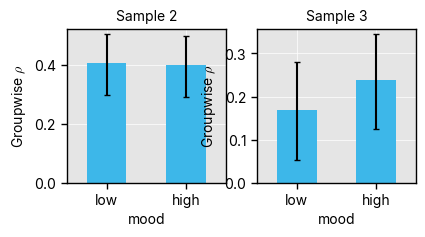

In [26]:
import sys
sys.path.append('..')
import pandas as pd
import torch as tc
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle
import plotting_utils
from weighted_correlation import weight_corr_for_dataframes, meta_spearman

with PaperStyle():

    fig, axes = plt.subplots(1, 2, figsize=(4.5,2))
    
    for m, mrt in enumerate(MRT):
        
        mood_correlations = []
        mood_groupwise_correlations = []
        for mood in ['low', 'high']:
            this_cir = plrnn_emi_cir.loc[(mrt, mood)]
            this_effects = effects.loc[(mrt, mood)].loc[this_cir.index]
            this_emi_occurrences = emi_occurrences.loc[(mrt, mood)].loc[this_cir.index]

            correlations = weight_corr_for_dataframes(this_cir, this_effects, this_emi_occurrences, 
                                                      method='spearman', axis=1, B=100, alternative='greater', 
                                                      p_method='permutation', ci_type='percentile', clip_ci=True, nan_policy='omit')
        
            correlations['signif_color'] = correlations['p_value'].apply(lambda p: 'C0' if p<0.05 else 'C1')
            mood_correlations.append(correlations['statistic'])
            dropped = correlations.loc[correlations['statistic'].isna()].index.to_list()
            if len(dropped) > 0:
                print(f'Dropped participants {dropped} in {mood}')

            overall_effect = pd.Series(meta_spearman(correlations['statistic'].dropna(), None))
            mood_groupwise_correlations.append(overall_effect)

        mood_groupwise_correlations = pd.concat(mood_groupwise_correlations, axis=1, keys=['low', 'high'], names=['mood'])
        mood_groupwise_correlations.T.plot(ax=axes[m], kind='bar', y='effect', ylabel=r'Groupwise $\rho$', title=f'Sample {mrt}', label='group-wise correlation',
                                           yerr=[mood_groupwise_correlations.loc['effect'] - mood_groupwise_correlations.loc['ci_lower'], 
                                                 mood_groupwise_correlations.loc['ci_upper'] - mood_groupwise_correlations.loc['effect']],
                                                 legend=False, rot=0)
        plotting_utils.adjust_ylim(axes[m], top=0.03)

        between_mood_corr = mood_correlations[0].corr(mood_correlations[1], method='spearman')
        print(f'Between-mood meta correlation: {between_mood_corr:.3f}')

        fisher_correlations = []
        for i in range(len(mood_correlations)):
            fisher_correlations.append(np.arctanh(np.clip(mood_correlations[i].astype(float), -0.999999, 0.999999)))
        t_test_result = ttest_ind(fisher_correlations[0].dropna(), fisher_correlations[1].dropna(), equal_var=False)
        print(f'T-test between moods: t={t_test_result.statistic:.3f}, p={t_test_result.pvalue:.3f}')
        
        # if SAVE:
        #     plt.savefig(data_utils.join_ordinal_bptt_path('results', '_paper', f'emi_rank_correlation_mrt{mrt}.svg'))
    # plt.tight_layout()
    plt.show()
    

Dropped participants [27, 29, 73, 74, 80, 102, 231, 234, 269, 271] in low
Dropped participants [27, 73, 74, 102, 231, 234, 269] in high
Between-mood meta correlation: 0.101
T-test between moods: t=-0.130, p=0.897


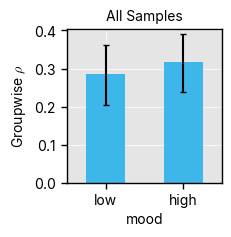

In [27]:
import sys
sys.path.append('..')
import pandas as pd
import torch as tc
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle
import plotting_utils

with PaperStyle():
    
    fig, ax = plt.subplots(1, 1, figsize=(2,2))
    mood_correlations = []
    mood_groupwise_correlations = []
    for mood in ['low', 'high']:
        this_cir = plrnn_emi_cir.droplevel('MRT').loc[mood]
        this_effects = effects.droplevel('MRT').loc[mood].loc[this_cir.index]
        this_emi_occurrences = emi_occurrences.droplevel('MRT').loc[mood].loc[this_cir.index]
        
        correlations = weight_corr_for_dataframes(this_cir, this_effects, this_emi_occurrences, 
                                                    method='spearman', axis=1, B=100, alternative='greater', 
                                                    p_method='permutation', ci_type='percentile', clip_ci=True, nan_policy='omit')
    
        correlations['signif_color'] = correlations['p_value'].apply(lambda p: 'C0' if p<0.05 else 'C1')
        mood_correlations.append(correlations['statistic'])
        dropped = correlations.loc[correlations['statistic'].isna()].index.to_list()
        if len(dropped) > 0:
            print(f'Dropped participants {dropped} in {mood}')

        overall_effect = pd.Series(meta_spearman(correlations['statistic'].dropna(), None))
        mood_groupwise_correlations.append(overall_effect)

    mood_groupwise_correlations = pd.concat(mood_groupwise_correlations, axis=1, keys=['low', 'high'], names=['mood'])
    mood_groupwise_correlations.T.plot(ax=ax, kind='bar', y='effect', ylabel=r'Groupwise $\rho$', title=f'All Samples', label='group-wise correlation',
                                        yerr=[mood_groupwise_correlations.loc['effect'] - mood_groupwise_correlations.loc['ci_lower'], 
                                                mood_groupwise_correlations.loc['ci_upper'] - mood_groupwise_correlations.loc['effect']],
                                                legend=False, rot=0)
    plotting_utils.adjust_ylim(ax, top=0.03)

    between_mood_corr = mood_correlations[0].corr(mood_correlations[1], method='spearman')
    print(f'Between-mood meta correlation: {between_mood_corr:.3f}')

    fisher_correlations = []
    for i in range(len(mood_correlations)):
        fisher_correlations.append(np.arctanh(np.clip(mood_correlations[i].astype(float), -0.999999, 0.999999)))
    t_test_result = ttest_ind(fisher_correlations[0].dropna(), fisher_correlations[1].dropna(), equal_var=False)
    print(f'T-test between moods: t={t_test_result.statistic:.3f}, p={t_test_result.pvalue:.3f}')
    
    if SAVE:
        plt.savefig(data_utils.join_ordinal_bptt_path('results', '_paper', f'emi_rank_correlation_median_split.svg'))
    plt.show()